In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scprep
import numpy as np
import pickle

In [2]:
import torch
from scipy.stats import gaussian_kde
import numpy as np

def kde(data, points_to_evaluate=None, bandwidth=None):
    """
    Perform kernel density estimation on n-dimensional data.
    
    Args:
        data (np.ndarray or torch.Tensor): Input data of shape (n_samples, n_dimensions)
        points_to_evaluate (np.ndarray or torch.Tensor, optional): Points at which to evaluate the KDE. 
            If None, the original data points are used.
        bandwidth (float, optional): Bandwidth for KDE. If None, Scott's rule is used.
    
    Returns:
        np.ndarray or torch.Tensor: Estimated density at each point in points_to_evaluate
    """
    is_torch = isinstance(data, torch.Tensor)
    
    if is_torch:
        original_dtype = data.dtype
        original_device = data.device
        data_np = data.cpu().numpy()
    else:
        data_np = data
    
    kde = gaussian_kde(data_np.T, bw_method=bandwidth)
    
    if points_to_evaluate is None:
        points_to_evaluate = data_np
    elif is_torch and isinstance(points_to_evaluate, torch.Tensor):
        points_to_evaluate = points_to_evaluate.cpu().numpy()
    
    result = kde(points_to_evaluate.T)
    
    if is_torch:
        result = torch.tensor(result, dtype=original_dtype, device=original_device)
    
    return result


In [3]:
res_dir = '../results_Mar4'
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
filtered_bc = np.load(f'{res_dir}/day0_filtered_barcodes.npy', allow_pickle=True)
adata_filtered = adata[filtered_bc,:]

In [4]:
sc.pp.log1p(adata_filtered)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
adata_filtered_0 = adata_filtered
adata_filtered_0 = adata_filtered_0[adata_filtered_0.obs['louvain'] == '5']

In [6]:
with open('../results_final_Dec22/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
X_phate = scaler.transform(adata.obsm['X_phate'])
traj_T = np.load('../results_final_Dec22/trajectories_T_extreme.npy')
traj_T_not_extreme = np.load('../results_final_Dec22/trajectories_T.npy')
start_pts = traj_T[0, :]
start_pts_not_extreme = traj_T_not_extreme[0, :]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
start_pts_unscaled = scaler.inverse_transform(start_pts)
start_pts_not_extreme_unscaled = scaler.inverse_transform(start_pts_not_extreme)

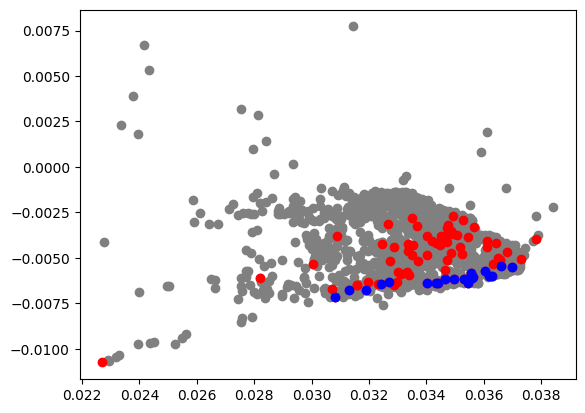

In [8]:
plt.scatter(adata_filtered_0.obsm['X_phate'][:,0], adata_filtered_0.obsm['X_phate'][:,1], color='gray')
plt.scatter(start_pts_not_extreme_unscaled[:,0], start_pts_not_extreme_unscaled[:,1], color='red')
plt.scatter(start_pts_unscaled[:,0], start_pts_unscaled[:,1], color='blue')


In [9]:
X_phate0 = scaler.transform(adata_filtered_0.obsm['X_phate'])

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


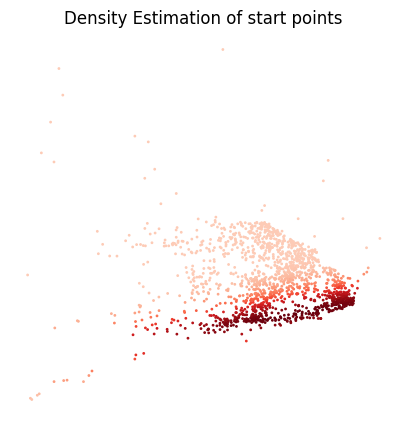

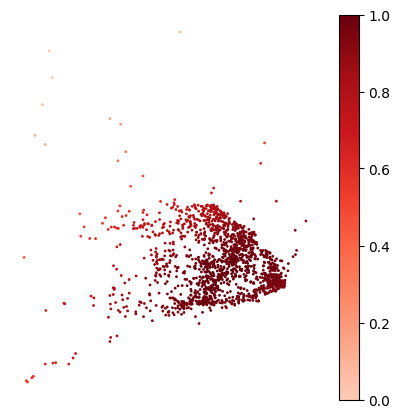

In [54]:
density_start_pts = kde(start_pts, X_phate0, bandwidth=5)
density_start_pts = (density_start_pts - density_start_pts.min()) / (density_start_pts.max() - density_start_pts.min())
density_start_pts_not_extreme = kde(start_pts_not_extreme, X_phate0, bandwidth=5)
density_start_pts_not_extreme = (density_start_pts_not_extreme - density_start_pts_not_extreme.min()) / (density_start_pts_not_extreme.max() - density_start_pts_not_extreme.min())

adata_filtered_0.obs['density_start_pts'] = density_start_pts
adata_filtered_0.obs['density_start_pts_not_extreme'] = density_start_pts_not_extreme


from matplotlib import colormaps
from matplotlib.colors import ListedColormap

cmap = colormaps['Reds']
cmap = ListedColormap(cmap(range(256)[50:]))

plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_phate0[:, 0], X_phate0[:, 1], c=density_start_pts, cmap=cmap, s=1, label='Extreme')
# plt.colorbar(scatter)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
plt.title('Density Estimation of start points')
# plt.legend()
# plt.savefig(f'{res_dir}/start_pts_kde.pdf', bbox_inches='tight', transparent=True, dpi=300)
plt.show()
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_phate0[:, 0], X_phate0[:, 1], c=density_start_pts_not_extreme, cmap=cmap, s=1, label='Not Extreme')
plt.colorbar(scatter)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
# plt.legend()
# plt.savefig(f'{res_dir}/start_pts_kde_not_extreme.pdf', bbox_inches='tight', transparent=True, dpi=300)
plt.show()



<Axes: >

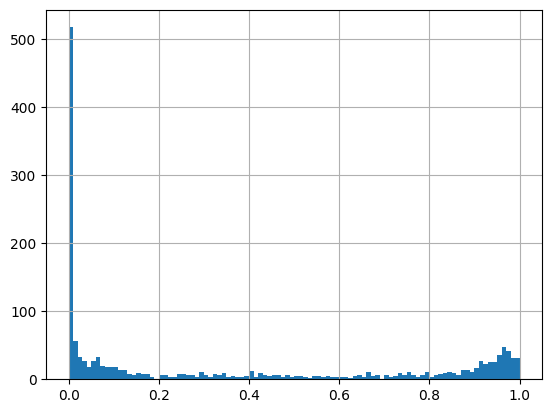

In [11]:
adata_filtered_0.obs['density_start_pts'].hist(bins=100)

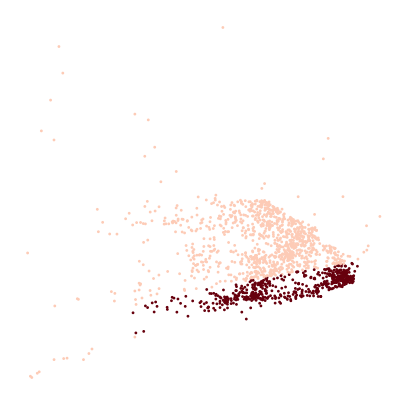

In [53]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_phate0[:, 0], X_phate0[:, 1], c=adata_filtered_0.obs['density_start_pts'] > 0.5, cmap=cmap, s=1, label='Extreme')
# plt.colorbar(scatter)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
# plt.legend()
# plt.savefig(f'{res_dir}/start_pts_kde.pdf', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [13]:
import magic
magic_op = magic.MAGIC(random_state=42)
magic_op.fit(adata_filtered_0.obsm['X_pca'])

Running MAGIC on 1582 cells and 50 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.15 seconds.
  Calculating affinities...
  Calculated affinities in 0.15 seconds.
Calculated graph and diffusion operator in 0.31 seconds.


MAGIC(knn_max=15, random_state=42)

In [14]:
X_magic = magic_op.transform(adata_filtered_0.to_df())

Running MAGIC with `solver='exact'` on 21465-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 2.12 seconds.


In [15]:
import pandas as pd
# Calculate Pearson correlation between 'start' and each gene in X_magic using vectorized operations
start_values = adata_filtered_0.obs['density_start_pts'].values

# Compute correlations in a vectorized way
# First center the data
start_centered = start_values - start_values.mean()
X_magic_centered = X_magic - X_magic.mean()

# Compute correlation coefficients
start_std = start_centered.std()
X_magic_std = X_magic_centered.std()
correlations = (start_centered @ X_magic_centered) / (len(start_values) * start_std * X_magic_std)

# Convert to Series for easier sorting/analysis
corr_series = pd.Series(correlations, index=X_magic.columns)
print(f"Top positively correlated genes with 'start':")
print(corr_series.sort_values(ascending=False).head(10))
print("\nTop negatively correlated genes with 'start':")
print(corr_series.sort_values().head(10))

Top positively correlated genes with 'start':
WRNIP1    0.855471
CKS1B     0.853418
RALBP1    0.849945
ALKBH3    0.849720
UQCC3     0.849450
CENPN     0.848279
EMC8      0.847464
ITGAE     0.847222
POLR2K    0.844540
GTF2A2    0.844303
dtype: float64

Top negatively correlated genes with 'start':
BNIP3L     -0.794333
NEAT1      -0.767468
ARPC1B     -0.750994
SLC16A4    -0.742273
RHOQ       -0.739629
WIPI1      -0.736358
CXXC4      -0.736091
MGST3      -0.723794
ALKBH7     -0.721791
C19orf66   -0.719670
dtype: float64


<Axes: >

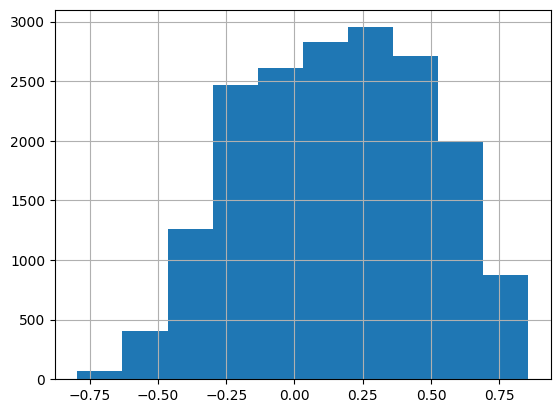

In [16]:
corr_series.hist()

In [17]:
corr_series['EPCAM']

0.5058070454167213

In [18]:
corr_series['CAV1']

0.3756090884157218

In [24]:
adata_filtered_0.obs['proliferation_category'] = (adata_filtered_0.obs['density_start_pts'] < 0.5).map({True: 'low', False: 'high'})

<Axes: >

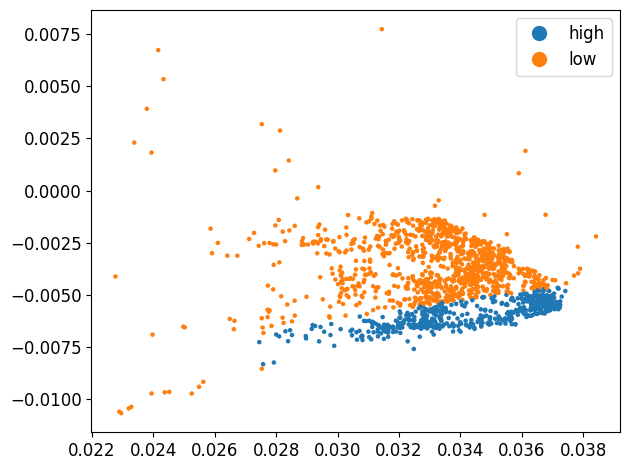

In [27]:
scprep.plot.scatter2d(adata_filtered_0.obsm['X_phate'], c=adata_filtered_0.obs['proliferation_category'])

In [28]:
sc.tl.rank_genes_groups(adata_filtered_0, 'proliferation_category', method='wilcoxon')

In [31]:
result = sc.get.rank_genes_groups_df(adata_filtered_0, group='high')
result

,names,scores,logfoldchanges,pvals,pvals_adj
0,HMGB2,24.966988,1.803903,1.396493e-137,2.997572e-133
1,CKS1B,24.311441,1.577770,1.483700e-130,1.592381e-126
2,H2AFZ,24.170048,0.890836,4.596423e-129,3.288741e-125
3,DEK,21.514694,0.719021,1.134255e-102,6.086696e-99
4,TPX2,21.380985,2.094721,2.008481e-101,8.622409e-98
...,...,...,...,...,...
21460,COL1A1,-14.715906,-0.438216,5.095935e-49,2.187685e-46
21461,RPS4X,-15.638409,-0.252294,3.985622e-55,2.444325e-52
21462,EEF1A1,-16.619677,-0.284209,5.020207e-62,3.848527e-59
21463,MALAT1,-16.959730,-0.384456,1.630937e-64,1.522090e-61


In [32]:
result

,names,scores,logfoldchanges,pvals,pvals_adj
0,HMGB2,24.966988,1.803903,1.396493e-137,2.997572e-133
1,CKS1B,24.311441,1.577770,1.483700e-130,1.592381e-126
2,H2AFZ,24.170048,0.890836,4.596423e-129,3.288741e-125
3,DEK,21.514694,0.719021,1.134255e-102,6.086696e-99
4,TPX2,21.380985,2.094721,2.008481e-101,8.622409e-98
...,...,...,...,...,...
21460,COL1A1,-14.715906,-0.438216,5.095935e-49,2.187685e-46
21461,RPS4X,-15.638409,-0.252294,3.985622e-55,2.444325e-52
21462,EEF1A1,-16.619677,-0.284209,5.020207e-62,3.848527e-59
21463,MALAT1,-16.959730,-0.384456,1.630937e-64,1.522090e-61


In [34]:
result[result['names'] == 'EPCAM']

,names,scores,logfoldchanges,pvals,pvals_adj
3904,EPCAM,1.178886,0.543819,0.238444,1.0


In [36]:
result[result['names'].isin(['EPCAM', 'CAV1', 'MMP7', 'VCAN', 'ANXA5', 'CD44'])]

,names,scores,logfoldchanges,pvals,pvals_adj
685,CAV1,5.062587,0.190585,4.136056e-07,0.000011
3904,EPCAM,1.178886,0.543819,2.384437e-01,1.000000
20258,MMP7,-0.890318,-0.354696,3.732951e-01,1.000000
20310,CD44,-0.936718,0.033334,3.489037e-01,1.000000
20889,ANXA5,-2.021186,-0.021666,4.326047e-02,0.301908
21068,VCAN,-2.687423,-0.073171,7.200577e-03,0.069981


In [40]:
result.to_csv('../results_Mar4/day0_bottom_cluster_hi_prolif_deg.csv', index=False)

In [51]:
pd.DataFrame(corr_series.sort_values(ascending=False).dropna(), columns=['Pearson_corr']).to_csv('../results_Mar4/day0_bottom_cluster_corr_prolif_density.csv')